Построить модель градиентного бустинга для многоклассовой классификации для показателя RiskVar на 1 и 2 частях набора данных freMPL. Необходимо предобработать исходные данные (данные содержат ряд других категориальных признаков, не рассматривавшихся на занятиях). Оценить результаты построенного классификатора, выявить возможные проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем. Можно использовать различные методы для подбора гиперпараметров

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
import itertools
import warnings
warnings.simplefilter('ignore')

In [3]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [4]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [5]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 20 columns):
Exposure       40732 non-null float64
LicAge         40732 non-null int64
VehAge         40732 non-null object
Gender         40732 non-null int64
MariStat       40732 non-null int64
SocioCateg     40732 non-null object
VehUsage       40732 non-null object
DrivAge        40732 non-null int64
HasKmLimit     40732 non-null int64
BonusMalus     40732 non-null int64
VehBody        40732 non-null object
VehPrice       40732 non-null object
VehEngine      40732 non-null object
VehEnergy      40732 non-null object
VehMaxSpeed    40732 non-null object
VehClass       40732 non-null object
ClaimAmount    40732 non-null float64
RiskVar        40732 non-null float64
Garage         40732 non-null object
ClaimInd       40732 non-null int64
dtypes: float64(3), int64(7), object(10)
memory usage: 6.2+ MB


Предобработайте данные

In [8]:
df.drop(['RecordBeg', 'RecordEnd'], axis=1, inplace=True)

In [9]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [10]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [11]:
NUM_FEATS = ['Exposure','ClaimAmount','RiskVar','LicAge','Gender','MariStat','DrivAge','HasKmLimit','BonusMalus','ClaimInd']

In [12]:
CAT_FEATS = ['VehAge','SocioCateg','VehUsage','VehBody','VehPrice','VehEngine','VehEnergy','VehMaxSpeed','VehClass','Garage']

In [14]:
df = pd.get_dummies(data=df, columns=CAT_FEATS)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,...,VehMaxSpeed_220+ km/h,VehClass_0,VehClass_A,VehClass_B,VehClass_H,VehClass_M1,VehClass_M2,Garage_Collective garage,Garage_None,Garage_Private garage
0,0.583,366,0,0,55,0,72,0.000000,15.0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.200,187,1,1,34,0,80,0.000000,20.0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.083,169,0,0,33,0,63,0.000000,17.0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.375,170,0,0,34,0,63,0.000000,17.0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.500,224,1,0,53,0,72,1418.610272,19.0,1,...,0,1,0,0,0,0,0,0,1,0


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде [0, num_classes]. Поэтому, вычтем из значений переменной RiskVar единицу.

In [15]:
df['RiskVar'] -= 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений RiskVar, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [17]:
data = df.groupby('RiskVar')['RiskVar'].count().to_frame()
data = data.rename(columns={"RiskVar": "Count"})

In [18]:
FreqCount = pd.DataFrame(data, columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


In [19]:
FreqCount.Freq.sum()

1.0

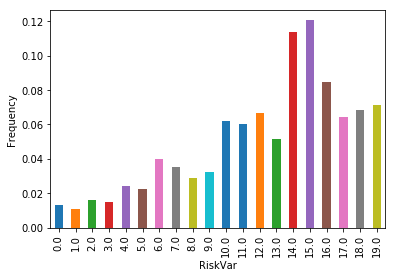

In [20]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец weight. Присвоим ему некоторые значения, например, можно задать 0.5 для значений RiskVar 14 и 15, а для остальных - 1 (Для этого можем использовать функцию np.where и метод isin для pandas.Series). Также можно попробовать какой-либо другой способ задания весов.

In [21]:
df['weight'] = 1

In [24]:
df.loc[df.RiskVar.isin([14, 15]), 'weight'] = 0.5

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [25]:
X = df.drop(columns=['Exposure', 'RiskVar'])
y = df['RiskVar']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты DMatrix для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр weight равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр data.

In [27]:
xgb_train = xgb.DMatrix(x_train.drop(columns=['weight']).values,
                        y_train.values,
                        weight=x_train['weight'].values)

xgb_valid = xgb.DMatrix(x_valid.drop(columns=['weight']).values,
                        y_valid.values)

xgb_test = xgb.DMatrix(x_test.drop(columns=['weight']).values,
                       y_test.values)

Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [31]:
def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': y.nunique()
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']),
                       nfold=5, metrics=['merror'], seed=21, maximize=False, early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0]
    return score

In [30]:
space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0.8, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
         'num_class': 20
        }

In [32]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

100%|█████████████████████████████████████████████| 10/10 [2:37:00<00:00, 708.31s/trial, best loss: 0.5718348000000001]


In [33]:
best

{'alpha': 0.8409873293031107,
 'colsample_bytree': 0.9756807071714584,
 'eta': 0.41746806819774146,
 'lambda': 0.356654633249716,
 'max_depth': 4,
 'min_child_weight': 1.632651298075538,
 'num_boost_round': 191.0,
 'subsample': 0.857213051817846}

In [35]:
best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params

{'alpha': 0.8409873293031107,
 'colsample_bytree': 0.9756807071714584,
 'eta': 0.41746806819774146,
 'lambda': 0.356654633249716,
 'max_depth': 15,
 'min_child_weight': 1.632651298075538,
 'num_boost_round': 191.0,
 'num_class': 20,
 'subsample': 0.857213051817846,
 'objective': 'multi:softmax'}

Далее обучим нашу модель с оптимальными параметрами

In [37]:
progress = dict()
xgb_model = xgb.train(params=best_params, dtrain=xgb_train,
                        maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")],
                        early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.

In [38]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_model.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) 
    print('Accuracy on ' + str(dfset['set'])+':', accuracy_score(dfset['target'], class_preds)) 
    print('')

F1 Score on train: 0.7318672839506173
Accuracy on train: 0.7318672839506173

F1 Score on valid: 0.29525368248772504
Accuracy on valid: 0.29525368248772504

F1 Score on test: 0.2988543371522095
Accuracy on test: 0.2988543371522095



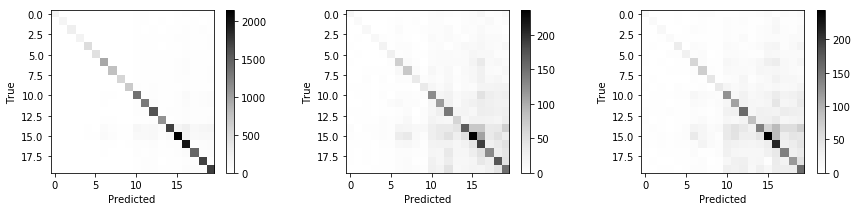

In [40]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Модель сильно переобучена.Классы дисбалансированы, классы с метками 15 и 16 определяются лучше всего. Возможно будет эффективно уменьшение количества классов, объединение части